# CLU - Common Loop Utils

    pip install clu

https://github.com/google/CommonLoopUtils

This package is usually used with
[JAX](https://github.com/google/jax)
/
[Flax](https://github.com/google/flax)
ML projects, but it can also be used with other ML frameworks.

JAX/Flax are designed for flexibility and the user remains in control of the
training loop. Writing and maintaining your own training loop gives lots of
flexibility but also quickly leads to non-trivial amount of code that is
repeated in every project (and usually forked from an
[example](https://flax.readthedocs.io/en/latest/examples.html)
in the first place).

`clu` provides small independent helpers to make the training loop shorter and
easier to read, while keeping maximum flexibility.

**This Colab** walks you through the different modules of `clu` with simple
example code for showcasing the important concepts and to be pasted into your
training loop to get started using `clu`.

### Setup

In [ ]:
!pip install -q clu

     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 184kB 40.7MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 122kB 50.3MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 


In [ ]:
!pip show clu

Name: clu
Version: 0.0.4
Summary: Set of libraries for ML training loops in JAX.
Home-page: http://github.com/google/CommonLoopUtils
Author: Common Loop Utils Authors
Author-email: no-reply@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: flax, tensorflow-datasets, jaxlib, tensorflow, absl-py, ml-collections, numpy, jax
Required-by: 


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

In [ ]:
import chex
chex.set_n_cpu_devices(8)  # Simulate 8 local devices in a CPU Colab runtime.

### `clu.metric_writers`

The module [`metric_writers`] provides a simple [interface] to write time series
metrics in a unified way.

Metric writers provided:

- `SummaryWriter`: Uses `tf.summary` to write summary files. For display in
  TensorBoard.
- `LoggingWriter`: Simply writes values to the INFO log. This obviously only
  supports data types that can be converted to text but is still helpful for
  seeing the training progress on the command line.
- `TorchTensorboardWriter`: Uses `torch.utils.tensorboard` to write summary
  files. Use this writer for the Pytorch-based code.

Additional we provide metric writers to combine multiple metric writers
(`MultiWriter`) and to move the write operation to a background thread
(`AsyncWriter`).

[`metric_writers`]: https://github.com/google/CommonLoopUtils/blob/master/clu/metric_writers/__init__.py
[interface]: https://github.com/google/CommonLoopUtils/blob/master/clu/metric_writers/interface.py


In [ ]:
from absl import logging
logging.set_verbosity(logging.INFO)

In [ ]:
logdir = './metrics'

In [ ]:
from clu import metric_writers

# Handy shortcut to create create async logging/tensorboard writer.
writer = metric_writers.create_default_writer(logdir)
for step in range(10):
  writer.write_scalars(step, dict(loss=0.9**step))

INFO:absl:[0] loss=1.000000
INFO:absl:[1] loss=0.900000
INFO:absl:[2] loss=0.810000
INFO:absl:[3] loss=0.729000
INFO:absl:[4] loss=0.656100
INFO:absl:[5] loss=0.590490
INFO:absl:[6] loss=0.531441
INFO:absl:[7] loss=0.478297


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./metrics

### `clu.periodic_actions`

[`periodic_actions`] are simple helpers that allow you to do in the training
loop at regular intervals. Currently we support

- `PeriodicAction`, `PeriodicCallback`: To implement your own actions.
- `Profile`: To create TensorBoard compatible profiles.
- `ReportProgress`: To continuously print progress status updates.

[`periodic_actions`]: https://github.com/google/CommonLoopUtils/blob/master/clu/periodic_actions.py

In [ ]:
from clu import periodic_actions

total_steps = 100
hooks = [
    # Outputs progress via metric writer (in this case logs & TensorBoard).
    periodic_actions.ReportProgress(
        num_train_steps=total_steps,
        every_steps=10, writer=writer),
    periodic_actions.Profile(logdir=logdir)
]

for step in range(total_steps):
  for hook in hooks:
    hook(step)

INFO:absl:Setting work unit notes: 210769.0 steps/s, 10.0% @10, ETA: 0m
INFO:absl:[10] steps_per_sec=210769.045226
INFO:absl:Setting work unit notes: 652.9 steps/s, 20.0% @20, ETA: 0m
INFO:absl:[20] steps_per_sec=652.911582
INFO:absl:Setting work unit notes: 938.2 steps/s, 30.0% @30, ETA: 0m
INFO:absl:Setting work unit notes: 794.8 steps/s, 40.0% @40, ETA: 0m
INFO:absl:Setting work unit notes: 1611.5 steps/s, 50.0% @50, ETA: 0m
INFO:absl:Setting work unit notes: 2845.3 steps/s, 60.0% @60, ETA: 0m
INFO:absl:Setting work unit notes: 2009.5 steps/s, 70.0% @70, ETA: 0m
INFO:absl:Setting work unit notes: 2638.8 steps/s, 80.0% @80, ETA: 0m
INFO:absl:Setting work unit notes: 2503.8 steps/s, 90.0% @90, ETA: 0m
INFO:absl:[30] steps_per_sec=938.197110
INFO:absl:[40] steps_per_sec=794.767120
INFO:absl:[50] steps_per_sec=1611.520344
INFO:absl:[60] steps_per_sec=2845.332067
INFO:absl:[70] steps_per_sec=2009.536221


In [ ]:
# If you click on "refresh" in above TensorBoard you'll now see a new
# "steps_per_sec" metric...
!ls -lh metrics

INFO:absl:[80] steps_per_sec=2638.756842
INFO:absl:[90] steps_per_sec=2503.763133


total 4.0K
-rw-r--r-- 1 root root 1.3K Jul  1 11:04 events.out.tfevents.1625137487.9d25b00e56c8.63.5.v2


### `clu.metrics`

The [`metrics`] module provides a framework for functional metric computation.
Note that this module does **not** include the actual metric definitions (other
than `metrics.Accuracy` that is provided for demonstration purposes), but
rather provides abstractions that can be used to compute metrics in a
distributed distributed environment.

This section is a bit longer than the previous sections and walks you through
the following parts:

1. How `metrics.Metric` is computed, and defining "averageable" metrics.
2. Using `metrics.Collection` to compute several metrics at once.
3. Aggregating in an evaluation step that is transformed by `pmap()`.
4. Define a new metric with custom aggregation (i.e. non "averageable").


[`metrics`]: https://github.com/google/CommonLoopUtils/blob/master/clu/metrics.py

In [ ]:
from clu import metrics
import flax

# Metrics are computed in three steps:

# 1. Compute intermediate values from model outputs
accuracy_batch1 = metrics.Accuracy.from_model_output(
    logits=jnp.array([[-1., 1.], [1., -1.]]),
    labels=jnp.array([0, 0]),  # i.e. 1st incorrect, 2nd correct
)
accuracy_batch2 = metrics.Accuracy.from_model_output(
    logits=jnp.array([[-1., 1.], [1., -1.]]),
    labels=jnp.array([1, 0]),  # i.e. both correct
)

# 2. Intermediate values are aggregated
accuracy = accuracy_batch1
accuracy = accuracy.merge(accuracy_batch2)

# 3. Final metrics are computed from aggregated intermediate values:
accuracy.compute()

DeviceArray(0.75, dtype=float32)

In [ ]:
# It's easy to define your own metrics if they are "averageable":

AverageLoss = metrics.Average.from_output('loss')

AverageLoss.from_model_output(
    loss=jnp.array([1.1, 3.3])
).compute()

DeviceArray(2.2, dtype=float32)

In [ ]:
# You can provide a functional to derive the value-to-be-averaged:

# Note that our metric only uses the model output named "loss". There can be an
# arbitrary number of additional model outputs that we don't need here (**_).
AverageSquaredLoss = metrics.Average.from_fun(lambda loss, **_: loss**2)

AverageSquaredLoss.from_model_output(
    loss=jnp.array([1.1**.5, 3.3**.5])
).compute()

DeviceArray(2.1999998, dtype=float32)

In [ ]:
# Usually you would want to compute a collection of metrics from model outputs:

@flax.struct.dataclass  # <-- required for JAX transformations
class MyMetrics(metrics.Collection):
  loss : metrics.Average.from_output('loss')
  accuracy : metrics.Accuracy


# 1. Compute intermediate values from model outputs
my_metrics_batch1 = MyMetrics.single_from_model_output(
    logits=jnp.array([[-1., 1.], [1., -1.]]),
    labels=jnp.array([0, 0]),  # i.e. 1st incorrect, 2nd correct
    loss=jnp.array([3.3, 2.2]),
)
my_metrics_batch2 = MyMetrics.single_from_model_output(
    logits=jnp.array([[-1., 1.], [1., -1.]]),
    labels=jnp.array([1, 0]),  # i.e. both correct
    loss=jnp.array([2.2, 1.1]),
)

# 2. Intermediate values are aggregated
my_metrics = my_metrics_batch1.merge(my_metrics_batch2)

# 3. Final metrics are computed from aggregated intermediate values:
my_metrics.compute()

{'accuracy': DeviceArray(0.75, dtype=float32),
 'loss': DeviceArray(2.2, dtype=float32)}

In [ ]:
# Often you want to compute these metrics inside a pmap(). The framework
# provides the handy `Collection.gather_from_model_output` that will first
# compute the intermediate values, then call `jax.lax.all_gather()` to gather
# the intermediate values from all the devices (in a multi-host setup that's
# all the devices in the mesh, not only the local devices), and then reduce them
# by calling `Metric.merge()` in a `jax.lax.scan()` loop.

# Sounds complicated? Using it is actually surprisingly simple:

def fake_model(params, batch):
  del params  # Fake.
  return batch

def eval_step(params, batch):
  model_outputs = fake_model(params, batch)
  # IMPORTANT: If you call `.single_from_model_output()` here, then all values
  # from devices after the first device will be ignored for the metric
  # computation.
  return MyMetrics.gather_from_model_output(**model_outputs)

eval_step_p = jax.pmap(eval_step, axis_name='batch')

my_metrics = None
for batch in [
  # Single batch of data pmapped on two devices in parallel.
  dict(
    logits=jnp.array([
        # Batch for device 1
        [[-1., 1.], [1., -1.]],
        # Batch for device 2
        [[-1., 1.], [1., -1.]],
    ]),
    labels=jnp.array([
        # Batch for device 1
        [0, 0],
        # Batch for device 2
        [1, 0],
    ]),
    loss=jnp.array([
        # Batch for device 1
        [3.3, 2.2],
        # Batch for device 2
        [2.2, 1.1],
    ]),
  ),
]:
  # Note: The metrics returned from pmapped eval_step still need to be
  # unreplicated here.
  # By the way: The framework detects if you forget to call unreplicate() here
  # and will raise a ValueError in that case...
  update = eval_step_p(None, batch).unreplicate()
  my_metrics = update if my_metrics is None else my_metrics.merge(my_metrics)

my_metrics.compute()

{'accuracy': DeviceArray(0.75, dtype=float32),
 'loss': DeviceArray(2.2, dtype=float32)}

In [ ]:
# You can also provide your own aggregation logic:

@flax.struct.dataclass
class Precision(metrics.Metric):
  """Computes the precision from model outputs `logits` and `labels`."""

  true_positives: jnp.array
  pred_positives: jnp.array

  @classmethod
  def from_model_output(cls, *, logits: jnp.array, labels: jnp.array,
                        **_) -> metrics.Metric:
    assert logits.shape[-1] == 2, "Expected binary logits."
    preds = logits.argmax(axis=-1)
    return cls(
        true_positives=((preds == 1) & (labels == 1)).sum(),
        pred_positives=(preds == 1).sum(),
    )

  def merge(self, other: metrics.Metric) -> metrics.Metric:
    # Note that for precision we cannot average metric values because the
    # denominator of the metric value is pred_positives and not every batch of
    # examples has the same number of pred_positives (as opposed to e.g.
    # accuracy where every batch has the same number of)
    return type(self)(
        true_positives=self.true_positives + other.true_positives,
        pred_positives=self.pred_positives + other.pred_positives,
    )

  def compute(self):
    return self.true_positives / self.pred_positives


Precision.from_model_output(
    # 1 TP, 1 FN -- 2 pred_positives -- precision = 1.0
    logits=jnp.array([[-1., 1.], [1., -1.]]),
    labels=jnp.array([1, 1]),  # i.e. 1st incorrect, 2nd correct
).merge(
    Precision.from_model_output(
        # 1 TP, 1 FP -- 2 pred_positives -- precision = 0.5
        logits=jnp.array([[-1., 1.], [-1., 1.]]),
        labels=jnp.array([1, 0]),  # i.e. 1st incorrect, 2nd correct
    )
).compute()

# If one incorrectly used metrics.Average to aggregate the metric, the final
# value would be 0.75 because both batches have the same weight in terms of
# examples. But the first batch constains 2 pred_positives and should thus be
# weighted 2x, resulting in the correct (1 + 1) / (1 + 2) == 0.66

DeviceArray(0.6666667, dtype=float32)

### `clu.deterministic_data`

The [`deterministic_data`] module sets up a [`tf.data.Dataset`] with useful
features:

- Specify split by name or [ReadInstruction].
- Reproducibly generating unique random keys for every batch and preprocessing
  operation. This makes it possible to train deterministically, achieving
  exactly the same results when starting with the same seeds, even in a
  multihost setup.
- Multiple levels of batch dimensions with support for completing partial
  batches with filler values.
- Predefined preprocessing operations that can be configured and chained with
  a configuration string. See [`clu.preprocess_specs`] below.
- Shard your dataset across multiple process. This necessary to efficiently
  train with multiple VMs.


This works well with [`tensorflow_datasets`] which can download/prepare hundreds
of datasets.

[`tf.data.Dataset`]: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
[`tensorflow_datasets`]: https://www.tensorflow.org/datasets
[`deterministic_data`]: https://github.com/google/CommonLoopUtils/blob/master/clu/deterministic_data.py
[ReadInstruction]: https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/core/tfrecords_reader.py
[`clu.preprocess_specs`]: #scrollTo=049FEFBq-9i2


In [ ]:
# First fetch "tf_flowers" dataset.
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_builder = tfds.builder('tf_flowers')
dataset_builder.download_and_prepare()
dataset_builder.info

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmprjxab6_ctfds
INFO:absl:Generating dataset tf_flowers (/root/tensorflow_datasets/tf_flowers/3.0.1)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1.incompleteLGYFS1




Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
from clu import deterministic_data
import jax

# In a multi-host setup this would split the entire dataset evenly across hosts.
# Colab runtime is always a single host, so this would not really be needed.
train_split = deterministic_data.get_read_instruction_for_host(
    "train", dataset_builder.info.splits["train"].num_examples)

def preprocess_fn(features):
  # Minimalistic preprocessing function to make images have the same dimensions
  # so they can be batched as dense tensors.
  features['image'] = tf.image.resize(features['image'], [224, 224])
  return features

batch_size = 128
train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=train_split,
    # This RNG key will be used to derive all randomness in shuffling, data
    # preprocessing etc.
    rng=jax.random.PRNGKey(0),
    shuffle_buffer_size=100,
    # Depending on TPU/other runtime, local device count will be 8/1.
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=42,
    preprocess_fn=preprocess_fn,
    shuffle=True)

INFO:absl:Constructing tf.data.Dataset for split ReadInstruction([_RelativeInstruction(splitname='train', from_=0, to=3670, unit='abs', rounding='closest')]), from /root/tensorflow_datasets/tf_flowers/3.0.1


In [ ]:
batch = next(iter(train_ds))
batch.keys()

dict_keys(['image', 'label'])

In [ ]:
# local devices, per device batch size, height, width, channels
batch['image'].shape

TensorShape([8, 16, 224, 224, 3])

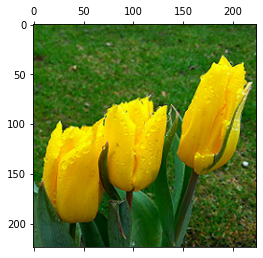

In [ ]:
from matplotlib import pyplot as plt
plt.matshow(batch['image'][0, 0] / 255.);

### `clu.preprocess_specs`

The module [`preprocess_specs`] allows to define preprocessing functions from
simpler building blocks.

The module provides a dataclass abstraction that transforms `Features` (a
dictionary of TensorFlow tensors), and a parser that lets you chain multiple
of these preprocessing steps with a string specification. This is very useful
to try different preprocessing functions by sweeping over a hyper parameter
that is this string representation.

The module does **not** include any preprocessing functions. They need to be
defined by the user.

[`preprocess_specs`]: https://github.com/google/CommonLoopUtils/blob/master/clu/preprocess_spec.py
[`clu.deterministic_data`]: #scrollTo=Nx6H0936Q3N0

INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/tf_flowers/3.0.1


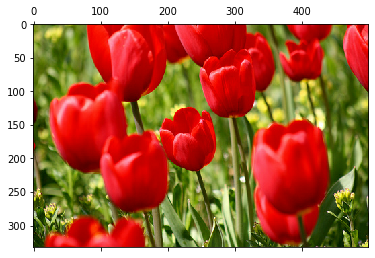

In [ ]:
img_orig = next(iter(dataset_builder.as_dataset('train')))['image']
plt.matshow(img_orig.numpy() / 255.);

([224, 224, 3], 0.0, 1.0)

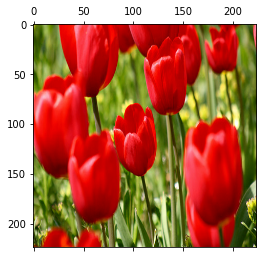

In [ ]:
# Simple example of image feature transormation:
img = tf.cast(img_orig, float) / 255.0
img = tf.image.resize(img, [256, 256])
img = tf.image.central_crop(img, 224 / 256)
plt.matshow(img.numpy())

img.shape.as_list(), img.numpy().min(), img.numpy().max()

In [ ]:
# Preprocessing specs are defined as dataclasses.

# This is a lot more verbose the first time it's defined, but it allows to
# create a preprocessing library over time and then construct complicated
# preprocessing pipelines with a single string...

import dataclasses
from typing import Optional

from clu import preprocess_spec

Features = preprocess_spec.Features

@dataclasses.dataclass
class ToFloat:
  name: str = "image"
  def __call__(self, features: Features) -> Features:
    return {
        k: tf.cast(v, tf.float32) / 255.0 if k == self.name else v
        for k, v in features.items()
    }

@dataclasses.dataclass
class CentralCrop:
  size: int
  crop_factor: float = 0.875
  name: str = "image"

  def resize(self, img):
    resize_sz = int(self.size / self.crop_factor)
    img = tf.image.resize(img, [resize_sz] * 2)
    return tf.image.central_crop(img, self.crop_factor)

  def __call__(self, features: Features) -> Features:
    return {
        k: self.resize(v) if k == self.name else v
        for k, v in features.items()
    }

@dataclasses.dataclass
class Onehot:
  num_classes: int
  name: str
  def __call__(self, features: Features) -> Features:
    return {
        k: tf.one_hot(v, self.num_classes) if k == self.name else v
        for k, v in features.items()
    }

# Handy helper to auto-discover preprocess ops in namespace.
preprocess_spec.get_all_ops(__name__)

[('central_crop', __main__.CentralCrop),
 ('onehot', __main__.Onehot),
 ('to_float', __main__.ToFloat)]

In [ ]:
# A pre-processing function is a chain of operations:
preprocess_fn = preprocess_spec.PreprocessFn([
    ToFloat(), CentralCrop(224), Onehot(5, 'label')],
    # (TensorFlow has types that do not exist in JAX. In our case we don't have
    # any, so this flag does not change anything.)
    only_jax_types=True)

In [ ]:
# It's often useful to specify the entire `PreproccessFn` with a string config:
preprocess_fn = preprocess_spec.parse(
    spec="to_float()|central_crop(224)|onehot(5, name='label')",
    available_ops=dict(preprocess_spec.get_all_ops(__name__)),
)

In [ ]:
# While we can directly `.map()` the preprocessing function, we would usually
# use it as an argument to `deterministic_data.create_dataset()`
batch = next(iter(dataset_builder.as_dataset('train').map(preprocess_fn)))

INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/tf_flowers/3.0.1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features before preprocessing: {'image': 'uint8[None, None, 3]', 'label': 'int64[]'}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op ToFloat(name='image'):
{'image': 'float32[None, None, 3]', 'label': 'int64[]'}
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op CentralCrop(size=224, crop_factor=0.875, name='image'):
{'image': 'float32[224, 224, 3]', 'label': 'int64[]'}
INFO:absl:Features after op Onehot(num_classes=5, name='label'):
{'image': 'float32[224, 224, 3]', 'label': 'float32[5]'}
INFO:absl:Features after preprocessing: {'image': 'float32[224, 224, 3]', 'label': 'float32[5]'}


In [ ]:
batch['image'].shape.as_list(), batch['image'].numpy().max()

([224, 224, 3], 1.0)

In [ ]:
batch['label']

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>

### Complete evaluation

When evaluating on multiple devices, every device requires the same batch size.
Thus, it's not straightforward to evaluate a complete dataset if the number of
examples in that dataset is not divisible by the number of devices.

`clu` provides a simple recipe for this:

1. Pad incomplete batches, adding a boolean "mask" feature that indicates
   whether an example should be considered when computing metrics.
2. Take "mask" into consideration when computing metrics.

In [ ]:
dataset_builder = tfds.builder('mnist')
dataset_builder.download_and_prepare()

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: mnist/3.0.1
INFO:absl:Load dataset info from /tmp/tmpza456zjqtfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset mnist (/root/tensorflow_datasets/mnist/3.0.1)
local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



INFO:absl:Load dataset info from /root/tensorflow_datasets/mnist/3.0.1.incompleteP1IMHG
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.




Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_test_examples = dataset_builder.info.splits['test'].num_examples
num_test_examples

10000

In [ ]:
# For reference: Label distribution in complete test set.
import collections
collections.Counter(next(iter(dataset_builder.as_dataset('test').batch(num_test_examples)))['label'].numpy())

INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/mnist/3.0.1


Counter({0: 980,
         1: 1135,
         2: 1032,
         3: 1010,
         4: 982,
         5: 892,
         6: 958,
         7: 1028,
         8: 974,
         9: 1009})

In [ ]:
# Naive approach without padding.
batch_size = 128
local_batch_size = batch_size // jax.device_count()
test_ds = deterministic_data.create_dataset(
    dataset_builder,
    split='test',
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    shuffle=False)

INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/mnist/3.0.1


In [ ]:
def get_logits(images):
  # Always predict label=0
  return jnp.tile(jax.nn.one_hot(0, 10)[None], [len(images), 1])

def eval_step(batch):
  logits = get_logits(batch['image'])
  return metrics.Collection.create(
      accuracy=metrics.Accuracy
  ).gather_from_model_output(logits=logits, labels=batch['label'])

eval_step_p = jax.pmap(eval_step, axis_name='batch')

my_metrics = None
for batch in test_ds:
  batch = jax.tree_map(np.asarray, batch)
  update = eval_step_p(batch).unreplicate()
  my_metrics = update if my_metrics is None else my_metrics.merge(update)

# Note that accuracy should be exactly 0.098
my_metrics.compute()

{'accuracy': DeviceArray(0.09795673, dtype=float32)}

In [ ]:
# Difference is due to fact that number of examples in test set is not divisible
# by batch.
num_test_examples / batch_size
# Note that in this case we could have chosen a batch that both divides the
# number of examples in the batch size and is divisible by the number of local
# devices (e.g. 200), but that is not possible in the general case, and for
# performance/memory reasons we might be constrained for choice of batch size.

78.125

In [ ]:
# For completeness of the example, let's pretend we evaluate on multiple hosts.
test_split = deterministic_data.get_read_instruction_for_host(
    'test', num_test_examples)
str(test_split)

"ReadInstruction([_RelativeInstruction(splitname='test', from_=0, to=10000, unit='abs', rounding='closest')])"

In [ ]:
# Compute how many batches we need to contain the entire test set.
global_batch_size = batch_size * jax.process_count()
pad_up_to_batches = int(np.ceil(num_test_examples / global_batch_size))
# This should result in 112 padded examples at the very end.
global_batch_size * pad_up_to_batches - num_test_examples

112

In [ ]:
test_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=test_split,
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    # Pad with masked examples instead of dropping incomplete final batch.
    pad_up_to_batches=pad_up_to_batches,
    shuffle=False)

INFO:absl:Constructing tf.data.Dataset for split ReadInstruction([_RelativeInstruction(splitname='test', from_=0, to=10000, unit='abs', rounding='closest')]), from /root/tensorflow_datasets/mnist/3.0.1


In [ ]:
# Same cell as above, but this time with masking & correct final accuracy.

def eval_step(batch):
  logits = get_logits(batch['image'])
  return metrics.Collection.create(
      accuracy=metrics.Accuracy
  ).gather_from_model_output(
      logits=logits,
      labels=batch['label'],
      # IMPORTANT: You must pass in the "mask" feature as an additional model
      # output so `metrics.Accuracy` is aware of it. Otherwise the masked
      # examples would be used for the metric computation... This is due to the
      # fact that `metrics.Accuracy` can handle both with and without "mask".
      # In the usual case you would implement the metrics yourself and the code
      # would fail if you forget to specify the mask here.
      mask=batch['mask'],
  )

eval_step_p = jax.pmap(eval_step, axis_name='batch')

my_metrics = None
for batch in test_ds:
  batch = jax.tree_map(np.asarray, batch)
  update = eval_step_p(batch).unreplicate()
  my_metrics = update if my_metrics is None else my_metrics.merge(update)

my_metrics.compute()

{'accuracy': DeviceArray(0.098, dtype=float32)}